In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize

# Environment Setup

In [61]:
class StochasticPricingEnvironment:
    """
    Stochastic environment for dynamic pricing with customer valuation uncertainty.
    
    This environment simulates a single-product pricing scenario where:
    - Customers have valuations drawn from a known distribution
    - The probability of purchase depends on whether customer valuation >= price
    - Each round represents one customer interaction
    """
    def __init__(self, valuation_distribution):
        """
        Initialize the pricing environment.
        
        Args:
            valuation_distribution: A scipy.stats distribution representing customer valuations
        """
        self.valuation_dist = valuation_distribution
        
    def demand_probability(self, price):
        """
        Calculate the theoretical probability that a customer purchases at given price.
        
        This is the complement of the CDF: P(valuation >= price) = 1 - F(price)
        where F is the cumulative distribution function of customer valuations.
        
        Args:
            price: The price to evaluate
            
        Returns:
            Probability that a randomly drawn customer will purchase at this price
        """
        return 1 - self.valuation_dist.cdf(price)

    def simulate_round(self, price):
        """
        Simulate one customer interaction at the given price.
        
        Args:
            price: The price offered to the customer
            
        Returns:
            tuple: (sale_made, revenue) where:
                - sale_made: 1 if customer purchased, 0 otherwise
                - revenue: price if sale was made, 0 otherwise
        """
        # Draw a random customer valuation from the distribution
        valuation = self.valuation_dist.rvs()
        
        # Customer purchases if their valuation >= price
        sale_made = 1 if valuation >= price else 0
        
        # Revenue is price if sale was made, 0 otherwise
        revenue = sale_made * price
        
        return sale_made, revenue

# Agent Setup

In [ ]:
class UCBLikeAgent:
    """
    UCB1-based agent for dynamic pricing with inventory constraints.
    
    This agent implements a variant of the UCB1 algorithm adapted for:
    1. Dynamic pricing (instead of traditional MAB rewards)
    2. Inventory constraints (limited number of products to sell)
    3. Dual optimization: maximize revenue while respecting inventory constraint
    
    The algorithm maintains upper confidence bounds on revenue (f_UCB) and 
    lower confidence bounds on demand probability (c_LCB), then solves a 
    linear program to find the optimal price distribution.
    """
    
    def __init__(self, P, T, prices, confidence_bound=2, rho_penalty=1.0):
        """
        Initialize the UCB agent for constrained dynamic pricing.
        
        Args:
            P: Total inventory (number of products available)
            T: Time horizon (number of rounds)
            prices: List of available prices to choose from
            confidence_bound: Confidence parameter for UCB/LCB bounds
            rho_penalty: Penalty factor for inventory constraint (>1 = more conservative)
        """
        k = len(prices)

        # Environment parameters
        self.prices = prices  # Available price options
        self.K = k           # Number of price arms
        self.T = T           # Total number of rounds
        self.confidence_bound = confidence_bound  # UCB confidence parameter
        
        # Current state
        self.current_price_idx = None  # Index of currently selected price
        self.t = 0                     # Current round number
        
        # Statistics for each price arm
        self.avg_revenue = np.zeros(k)  # Average revenue per price
        self.avg_demand = np.zeros(k)   # Average demand probability per price
        self.N_pulls = np.zeros(k)      # Number of times each price was selected
        
        # Inventory management
        self.inventory = P               # Initial inventory
        self.remaining_inventory = P     # Current remaining inventory
        self.rho = P / T                # Target selling rate
        self.rho_penalty = rho_penalty  # Penalty factor for inventory constraint
        
        # History tracking
        self.history = {
            'prices': [],     # Selected prices over time
            'rewards': [],    # Observed revenues over time
            'purchases': [],  # Purchase indicators over time
            'inventory': []   # Inventory levels over time
        }
    
    def select_price(self):
        """
        Select the next price using UCB1 with inventory constraints.
        
        Strategy:
        1. If inventory is empty, return NaN (no meaningful price)
        2. First K rounds: explore each price once (initialization)
        3. Subsequent rounds: solve LP with UCB revenue bounds and LCB demand bounds
        
        Returns:
            Selected price, or np.nan if no inventory remaining
        """
        # No inventory left - cannot make meaningful pricing decisions
        if self.remaining_inventory < 1:
            self.current_price_idx = np.argmax(self.prices)  # Arbitrary selection
            return np.nan
            
        # Exploration phase: try each price at least once
        if self.t < self.K:
            self.current_price_idx = self.t
        # Exploitation-Exploration phase: use UCB with inventory constraints
        else:            
            # Compute upper confidence bounds on revenue for each price
            confidence_radius = self.confidence_bound * np.sqrt(np.log(self.t) / np.maximum(self.N_pulls, 1))
            f_ucbs = self.avg_revenue + confidence_radius
            
            # Compute lower confidence bounds on demand probability for each price
            c_lcbs = np.maximum(0, self.avg_demand - confidence_radius)
            
            # Solve linear program to get optimal price distribution
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            
            # Sample price according to computed distribution
            self.current_price_idx = np.random.choice(self.K, p=gamma_t)

        return self.prices[self.current_price_idx]

    def compute_opt(self, f_ucbs, c_lcbs): 
        """
        Solve constrained optimization problem to find optimal price distribution.
        
        Formulation:
        maximize: sum_i gamma_i * f_ucb_i (expected revenue)
        subject to: sum_i gamma_i * c_lcb_i <= rho_penalty * current_rho (inventory constraint)
                   sum_i gamma_i = 1 (probability constraint)
                   gamma_i >= 0 (non-negativity)
        
        where current_rho is the required selling rate to use remaining inventory.
        
        Args:
            f_ucbs: Upper confidence bounds on revenue for each price
            c_lcbs: Lower confidence bounds on demand probability for each price
            
        Returns:
            gamma: Probability distribution over prices
        """
        # Handle edge case: if no positive demand expected, choose highest revenue price
        if np.all(c_lcbs <= 1e-10):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1.0
            return gamma
        
        # Convert to minimization problem (negate revenues)
        c = -f_ucbs
        
        # Compute current required selling rate
        remaining_rounds = max(1, self.T - self.t)
        current_rho = max(self.remaining_inventory / remaining_rounds, 0)
        
        # Apply penalty to make constraint more conservative
        penalized_rho = current_rho * self.rho_penalty
        
        # Linear program constraints
        A_ub = [c_lcbs]              # Inventory constraint coefficients
        b_ub = [penalized_rho]       # Inventory constraint bound
        A_eq = [np.ones(self.K)]     # Probability constraint coefficients  
        b_eq = [1]                   # Probability constraint bound
        
        # Solve linear program
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                                 bounds=[(0, 1) for _ in range(self.K)], method='highs')
            if res.success:
                gamma = res.x
                # Ensure valid probability distribution
                gamma = np.maximum(gamma, 0)
                gamma = gamma / np.sum(gamma) if np.sum(gamma) > 0 else np.ones(self.K) / self.K
                return gamma
            else:
                # Fallback: uniform distribution
                return np.ones(self.K) / self.K
        except:
            # Fallback: uniform distribution
            return np.ones(self.K) / self.K
    
    def update(self, reward, purchased):
        """
        Update agent's statistics based on observed outcome.
        
        Args:
            reward: Revenue obtained (price if purchased, 0 otherwise)
            purchased: Boolean indicating if purchase was made
        """
        idx = self.current_price_idx
        
        # Update pull count
        self.N_pulls[idx] += 1
        
        # Update average revenue using incremental mean formula
        self.avg_revenue[idx] += (reward - self.avg_revenue[idx]) / self.N_pulls[idx]
        
        # Update average demand probability
        purchased_indicator = 1.0 if purchased else 0.0
        self.avg_demand[idx] += (purchased_indicator - self.avg_demand[idx]) / self.N_pulls[idx]
        
        # Update inventory only if purchase was actually made and inventory available
        if purchased and self.remaining_inventory > 0:
            self.remaining_inventory -= 1
        elif purchased and self.remaining_inventory <= 0:
            # This shouldn't happen with proper price selection, but handle gracefully
            reward = 0
            purchased = False
        
        # Record history
        self.history['prices'].append(self.prices[idx])
        self.history['rewards'].append(reward)
        self.history['purchases'].append(purchased)
        self.history['inventory'].append(self.remaining_inventory)
        
        # Increment time
        self.t += 1

    def get_best_price(self):
        """
        Return the price with highest average revenue observed so far.
        
        Returns:
            tuple: (best_price, best_average_revenue)
        """
        best_idx = np.argmax(self.avg_revenue)
        return self.prices[best_idx], self.avg_revenue[best_idx]

In [64]:
#define the optimal solution
def compute_clairvoyant(prices, environment, T, P):
    """
    Compute the optimal (clairvoyant) pricing strategy with full information.
    
    This function solves the linear program that an oracle with perfect knowledge
    of the demand probabilities would solve:
    
    maximize: sum_i gamma_i * price_i * demand_prob_i
    subject to: sum_i gamma_i * demand_prob_i <= P/T  (inventory constraint)
               sum_i gamma_i = 1                      (probability constraint)
               gamma_i >= 0                          (non-negativity)
    
    Args:
        prices: List of available prices
        environment: StochasticPricingEnvironment to get true demand probabilities
        T: Time horizon
        P: Total inventory
        
    Returns:
        tuple: (optimal_distribution, optimal_value, demand_probabilities, expected_revenues)
    """
    # Compute true demand probabilities for each price
    buying_probabilities = np.array([environment.demand_probability(p) for p in prices])
    
    # Expected revenue per selection for each price
    exp_reward = prices * buying_probabilities
    
    # Set up linear program (convert maximization to minimization)
    c = -exp_reward  # Negate for minimization
    
    # Inventory constraint: expected consumption rate <= inventory rate
    A_ub = [buying_probabilities]
    b_ub = [P / T]
    
    # Probability constraint: sum of probabilities = 1
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    # Solve the linear program
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                          bounds=[(0, 1) for _ in range(len(prices))], method='highs')
    
    gamma = res.x  # Optimal price distribution
    optimal_value = -res.fun  # Optimal expected revenue per round
    
    return gamma, optimal_value, buying_probabilities, exp_reward

**Theoretical Analysis**

In [65]:

print('=== Theoretical Analysis ===')

env=StochasticPricingEnvironment(valuation_distribution=valuation_dist)



opt_dist, opt_value, true_purchase_probs, true_rewards=compute_clairvoyant(prices=agent_params['prices'],environment=env,T=agent_params['T'],P=agent_params['P'])

optimal_idx = np.argmax(opt_dist)  # Index of the optimal price

for i in range(len(agent_params['prices'])):
    
    prices=agent_params['prices']
    marker = " ← OPTIMAL" if i == optimal_idx else ""
    print(f"  Price {prices[i]:2d}: p ={opt_dist[i]:5.1f}{marker}")

optimal_revenue = np.dot(prices, opt_dist)

print(f'\n=== Optimal revenue === \n         {optimal_revenue:.2f}')




=== Theoretical Analysis ===
  Price 20: p =  0.0
  Price 30: p =  0.0
  Price 40: p =  0.0
  Price 50: p =  0.6 ← OPTIMAL
  Price 60: p =  0.4
  Price 70: p =  0.0
  Price 80: p =  0.0

=== Optimal revenue === 
         54.04


# Simulation

In [71]:
def run_simulator(
    T,
    valuation_dist,
    env_config,
    agent_params,
    n_simulations=1,
    verbose=True
):
    selected_prices = []
    revenues = []
    sales = []
    cumulative_revenue = []
    total_revenue = 0
    best_prices = []
    first_inventory_empty = None

    # === Compute theoretical optimum once before all simulations ===
    env_theoretical = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )
    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env_theoretical,
        T=agent_params['T'],
        P=agent_params['P']
    )
    optimal_idx = np.argmax(opt_dist)
    optimal_revenue = np.dot(agent_params['prices'], opt_dist)


    for sim in range(n_simulations):
        
        print(f"\n=== Running UCB1 Pricing Simulation #{sim + 1} for {T} rounds ===")

        # Create environment and agent
        env = StochasticPricingEnvironment(
            valuation_distribution=valuation_dist
        )
        agent = UCBLikeAgent(**agent_params)

        for t in range(T):
            if agent.remaining_inventory < 1 and first_inventory_empty is None:
                first_inventory_empty = t
                if verbose:
                    print(f"Inventory empty for the first time at round {t}")
                    print("No more products in the inventory")

            price = agent.select_price()
            price_idx = agent.current_price_idx

            if agent.remaining_inventory <= 0:
                sale_made = False
                revenue = 0
            else:
                sale_made, revenue = env.simulate_round(price)

            agent.update(revenue, sale_made)

            selected_prices.append(price)
            revenues.append(revenue)
            sales.append(sale_made)
            total_revenue += revenue
            cumulative_revenue.append(total_revenue)

        best_price, best_avg_revenue = agent.get_best_price()
        best_prices.append(best_price)

        print(f"\nSimulation completed!")
        print(f"Total revenue: {total_revenue:.2f}")
        print(f"Average revenue per round: {total_revenue / T:.2f}")
        print(f"Agent's best price: {best_price} (avg revenue: {best_avg_revenue:.2f})")
        print(f"Theoretical optimal: {opt_dist} (expected revenue: {optimal_revenue:.2f})")

    price_to_idx = {p: i for i, p in enumerate(agent_params['prices'])}
    price_indices = [price_to_idx[p] for p in selected_prices if not np.isnan(p)]
    price_counts = np.bincount(price_indices, minlength=len(agent_params['prices']))        

    if verbose:
        print("\n=== Simulation Results ===")
        print("\nPrice selection frequency:")
        for i, (price, count) in enumerate(zip(agent_params['prices'], price_counts)):
            percentage = 100 * count / T
            marker = " ← OPTIMAL" if i == optimal_idx else ""
            print(f"  Price {price:2}: {count:4d} times ({percentage:5.1f}%){marker}")

    return {
        'price_counts': price_counts,
        'selected_prices': selected_prices,
        'revenues': revenues,
        'sales': sales,
        'cumulative_revenue': cumulative_revenue,
        'best_prices': best_prices,
        'first_inventory_empty': first_inventory_empty,
        'total_revenue': total_revenue,
        'opt_dist': opt_dist,
        'optimal_idx': optimal_idx,
        'optimal_revenue': optimal_revenue
    }


# Plot

In [67]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config):
    """
    Generate comprehensive visualizations and analysis of the UCB pricing algorithm.
    
    Args:
        T: Number of rounds
        revenues: List of revenues per round
        cumulative_revenue: List of cumulative revenues
        price_counts: Array of how many times each price was selected
        agent_params: Dictionary of agent parameters
        sales: List of sales indicators per round
        agent: The UCBLikeAgent instance
        valuation_dist: Customer valuation distribution
        env_config: Environment configuration
        
    Returns:
        Dictionary containing computed regret and revenue data
    """
    
    # === Theoretical Analysis ===
    print('=== Theoretical Analysis ===')

    env = StochasticPricingEnvironment(
        valuation_distribution=valuation_dist
    )

    opt_dist, opt_value, true_purchase_probs, true_rewards = compute_clairvoyant(
        prices=agent_params['prices'],
        environment=env,
        T=agent_params['T'],
        P=agent_params['P']
    )

    prices = agent_params['prices']
    optimal_idx = np.argmax(opt_dist)
    
    print("Optimal price distribution:")
    for i in range(len(prices)):
        marker = " ← OPTIMAL" if i == optimal_idx else ""
        print(f"  Price {prices[i]:2d}: p = {opt_dist[i]:5.3f}{marker}")

    optimal_revenue = np.dot(prices, opt_dist)
    print(f'\n=== Optimal Expected Revenue Per Round === \n         {optimal_revenue:.2f}')

    # === Performance Analysis ===
    theoretical_optimal_total = optimal_revenue * T
    total_revenue = sum(revenues)
    actual_regret = theoretical_optimal_total - total_revenue
    regret_cumulative = [optimal_revenue * (t+1) - cumulative_revenue[t] for t in range(T)]

    # === Comprehensive Visualization ===
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Cumulative Revenue vs Optimal
    axes[0, 0].plot(cumulative_revenue, label='UCB Agent', linewidth=2, color='blue')
    axes[0, 0].plot([optimal_revenue * (t+1) for t in range(T)], 
                    label='Theoretical Optimal', linestyle='--', linewidth=2, color='red')
    axes[0, 0].set_xlabel('Round')
    axes[0, 0].set_ylabel('Cumulative Revenue')
    axes[0, 0].set_title('Cumulative Revenue Comparison')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Cumulative Regret with theoretical bound
    axes[0, 1].plot(regret_cumulative, color='red', linewidth=2, label='Actual Regret')
    
    # Add theoretical regret bound for UCB (simplified)
    t_vals = np.arange(1, T + 1)
    K = len(agent_params['prices'])
    # Simplified UCB bound: O(sqrt(K log T) * sqrt(T))
    ucb_bound = np.sqrt(K * np.log(t_vals)) * np.sqrt(t_vals) * 2  # Scaled constant
    axes[0, 1].plot(t_vals, ucb_bound, '--', color='blue', alpha=0.7, 
                   label='UCB Regret Bound (scaled)')
    
    axes[0, 1].set_xlabel('Round')
    axes[0, 1].set_ylabel('Cumulative Regret')
    axes[0, 1].set_title('Cumulative Regret Over Time')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Price Selection Frequency
    bars = axes[1, 0].bar(prices, price_counts, alpha=0.7, color='skyblue')
    bars[optimal_idx].set_color('red')
    bars[optimal_idx].set_alpha(1.0)
    axes[1, 0].set_xlabel('Price')
    axes[1, 0].set_ylabel('Selection Frequency')
    axes[1, 0].set_title('Price Selection Distribution')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add percentage labels on bars
    for i, (bar, count) in enumerate(zip(bars, price_counts)):
        if count > 0:
            percentage = 100 * count / T
            axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + T*0.01,
                           f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

    # 4. Revenue per Round (moving average)
    window_size = min(50, T // 10)  # Adaptive window size
    if window_size > 1:
        moving_avg = np.convolve(revenues, np.ones(window_size)/window_size, mode='valid')
        axes[1, 1].plot(range(window_size-1, T), moving_avg, linewidth=2, 
                       label=f'Revenue (MA-{window_size})', color='blue')
    else:
        axes[1, 1].plot(revenues, linewidth=1, alpha=0.7, 
                       label='Revenue per Round', color='blue')
        
    axes[1, 1].axhline(optimal_revenue, color='red', linestyle='--', 
                       label=f'Optimal ({optimal_revenue:.2f})', linewidth=2)
    axes[1, 1].set_xlabel('Round')
    axes[1, 1].set_ylabel('Revenue')
    axes[1, 1].set_title(f'Revenue Convergence')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === Average Regret per Round: R(t)/t ===
    t_vals = np.arange(1, T + 1)
    regret_avg = np.array(regret_cumulative) / t_vals

    plt.figure(figsize=(10, 5))
    plt.plot(t_vals, regret_avg, label=r'$R(t)/t$ (Average Regret)', linewidth=2)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title("Average Regret Per Round")
    plt.xlabel("Round")
    plt.ylabel("Average Regret")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Regret Growth Analysis ===
    try:
        from scipy.stats import linregress
        
        # Fit regret growth in log-log scale
        t_vals_log = np.log(t_vals[T//2:])  # Use second half for better convergence
        regret_log = np.log(np.maximum(regret_cumulative[T//2:], 1e-6))
        
        if len(t_vals_log) > 10:  # Ensure enough data points
            slope, intercept, r_value, p_value, std_err = linregress(t_vals_log, regret_log)
            print(f"\n=== Regret Growth Analysis ===")
            print(f"Estimated regret exponent (log-log slope): {slope:.3f}")
            print(f"R-squared: {r_value**2:.3f}")
            print(f"Expected for UCB: ~0.5 (theory suggests O(sqrt(T)))")
    except Exception as e:
        print(f"Could not perform regret growth analysis: {e}")

    # === Summary Statistics ===
    convergence_rate = 100 * (1 - actual_regret/theoretical_optimal_total)
    sales_rate = 100 * sum(sales) / T
    
    print(f"\n=== Summary Statistics ===")
    print(f"Convergence rate: {convergence_rate:.1f}%")
    print(f"Average revenue per round: {total_revenue/T:.2f}")
    print(f"Revenue std deviation: {np.std(revenues):.2f}")
    print(f"Total sales made: {sum(sales)}")
    print(f"Sales rate: {sales_rate:.1f}%")
    print(f"Remaining inventory: {agent.remaining_inventory}")
    print(f"Total regret: {actual_regret:.2f}")
    print(f"Average regret per round: {actual_regret/T:.4f}")
    
    # Inventory utilization analysis
    inventory_used = agent_params['P'] - agent.remaining_inventory
    utilization_rate = 100 * inventory_used / agent_params['P']
    print(f"Inventory utilization: {utilization_rate:.1f}%")

    return {
        'cumulative_regret': regret_cumulative,
        'cumulative_revenue': cumulative_revenue,
        'optimal_revenue': optimal_revenue,
        'convergence_rate': convergence_rate,
        'sales_rate': sales_rate,
        'inventory_utilization': utilization_rate
    }


# Run the simulation

In [79]:
# Environment Configuration
env_config = {
    'valuation_mean': 50,  # Average customer valuation
    'valuation_std': 15,   # Standard deviation of customer valuations
    'demand_noise_std': 0.005  # Noise in demand probability
}

## Create a normal distribution for customer valuations
valuation_dist = stats.norm(loc=env_config['valuation_mean'], scale=env_config['valuation_std'])

T = 10000  # Number of rounds
inventory = 8000  # Inventory constraint

agent_params = {
    'P': inventory, #inventory constraint
    'T': T, #number of rounds
    'prices': [20, 40, 50, 60, 80], #set of prices 
    'confidence_bound': 1,  # UCB exploration parameter
    'rho_penalty': 0.7  
}

agent = UCBLikeAgent(**agent_params)

print(f"Customer valuation distribution: Normal(μ={env_config['valuation_mean']}, σ={env_config['valuation_std']})")
print(f"Number of price options: {len(agent_params['prices'])}")
print(f"UCB confidence bound: {agent_params['confidence_bound']}")
print(f'Inventory contrain: ',agent_params['P'])
print(f'Number of rounds:',agent_params['T'])

# set random seed for reproducibility
np.random.seed(42)

results = run_simulator(
    T=T,
    valuation_dist=valuation_dist,
    env_config=env_config,
    agent_params=agent_params,
    n_simulations=1,
    verbose=False
)

selected_prices = results['selected_prices']
revenues = results['revenues']
sales = results['sales']
cumulative_revenue = results['cumulative_revenue']
best_prices = results['best_prices']
first_inventory_empty = results['first_inventory_empty']
total_revenue = results['total_revenue']
price_counts = results['price_counts']

Customer valuation distribution: Normal(μ=50, σ=15)
Number of price options: 5
UCB confidence bound: 1
Inventory contrain:  8000
Number of rounds: 10000

=== Running UCB1 Pricing Simulation #1 for 10000 rounds ===

Simulation completed!
Total revenue: 297080.00
Average revenue per round: 29.71
Agent's best price: 40 (avg revenue: 30.38)
Theoretical optimal: [0. 1. 0. 0. 0.] (expected revenue: 40.00)


# Plot the results

=== Theoretical Analysis ===
Optimal price distribution:
  Price 20: p = 0.000
  Price 40: p = 1.000 ← OPTIMAL
  Price 50: p = 0.000
  Price 60: p = 0.000
  Price 80: p = 0.000

=== Optimal Expected Revenue Per Round === 
         40.00


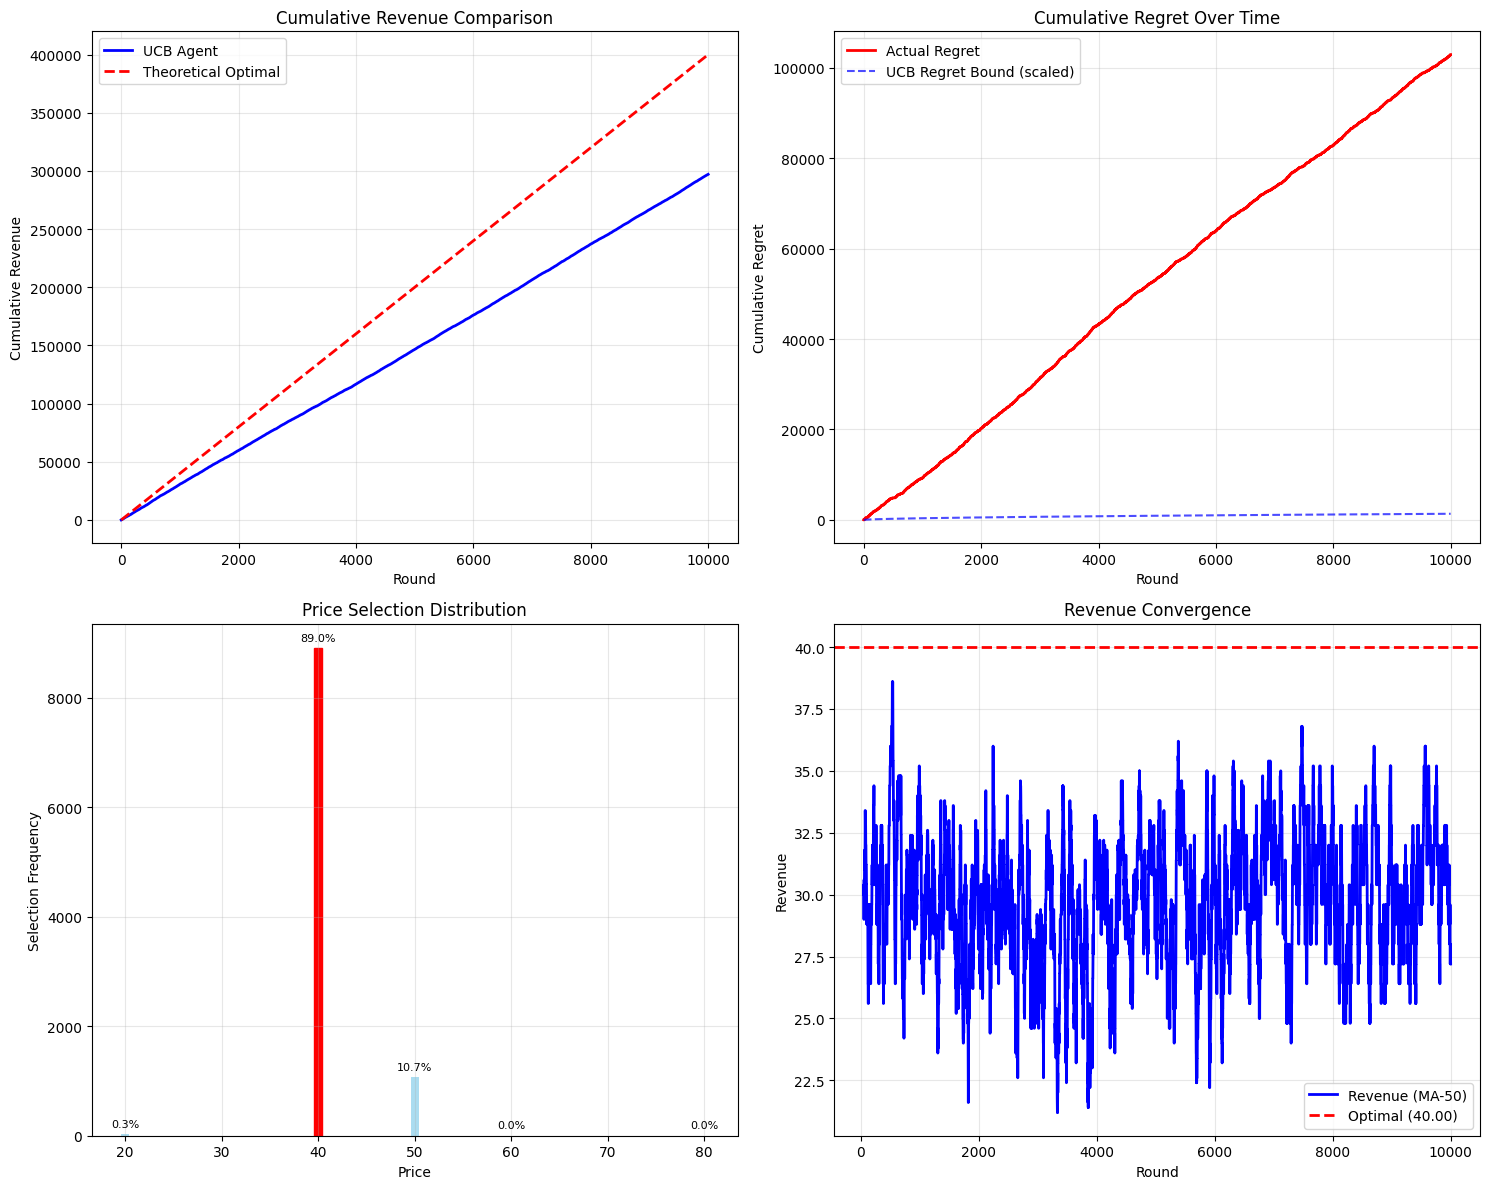

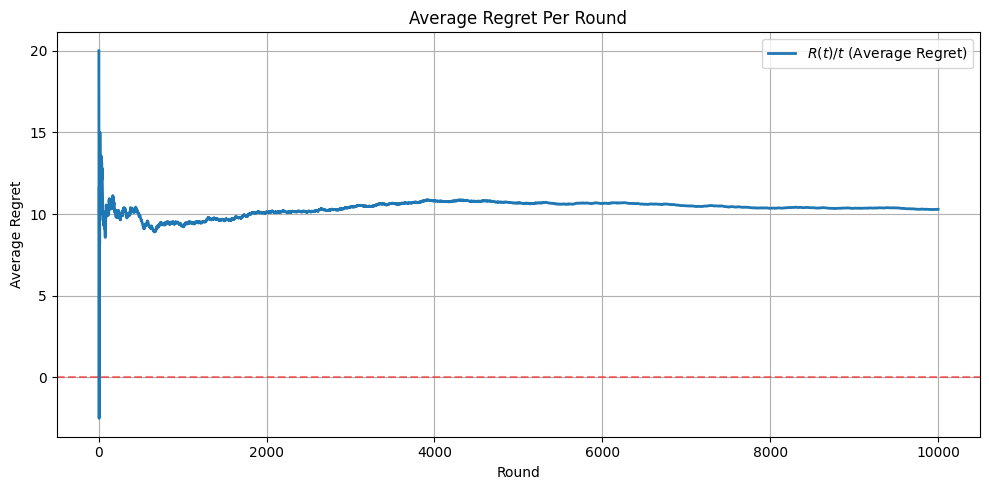


=== Regret Growth Analysis ===
Estimated regret exponent (log-log slope): 0.939
R-squared: 1.000
Expected for UCB: ~0.5 (theory suggests O(sqrt(T)))

=== Summary Statistics ===
Convergence rate: 74.3%
Average revenue per round: 29.71
Revenue std deviation: 18.19
Total sales made: 7309
Sales rate: 73.1%
Remaining inventory: 8000
Total regret: 102920.00
Average regret per round: 10.2920
Inventory utilization: 0.0%


In [80]:
plot_res=plot_results(T, revenues, cumulative_revenue, price_counts, 
                 agent_params, sales, agent, valuation_dist, env_config)
